First of all, we need to implement the SVM solver based on the SMO algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.datasets import mnist

Using TensorFlow backend.


We define some auxilary functions. The following two functions are related with the kernel function and kernel matrix

In [2]:
""" kernel part for SVM """
def kernel_func(x1,x2, kernel_type=None):
	if kernel_type is None:
		return np.dot( x1,x2)
	elif kernel_type["name"]=="GAUSSIAN":
		sigma = kernel_type["params"][0]
		return np.exp(- np.dot( x1-x2, x1-x2 )/(2*sigma**2)  )

def get_kernel_matrix( x1, x2, kernel_type=None ):
	num_samples_x1 = x1.shape[0]
	num_samples_x2 = x2.shape[0]
	kernel_matrix = np.zeros([num_samples_x1, num_samples_x2])
	for nrow in range(num_samples_x1 ):
		for ncol in range(num_samples_x2  ):
			kernel_matrix[nrow][ncol] = kernel_func(x1[nrow] , x2[ncol], kernel_type = kernel_type)
	return kernel_matrix

Then we need to implement the SVM solver part, which is encapsulated into a class

In [3]:
"""
Description: A SVM solver
Input:  training dataset (x,y), together with other hype-parameters
Return: a trained SVM model (solver) which is able to perform classification for a give x
"""
import numpy as np

""" kernel part for SVM """
def kernel_func(x1,x2, kernel_type=None):
	if kernel_type is None:
		return np.dot( x1,x2)
	elif kernel_type["name"]=="GAUSSIAN":
		sigma = kernel_type["params"][0]
		return np.exp(- np.dot( x1-x2, x1-x2 )/(2*sigma**2)  )

def get_kernel_matrix( x1, x2, kernel_type=None ):
	num_samples_x1 = x1.shape[0]
	num_samples_x2 = x2.shape[0]
	kernel_matrix = np.zeros([num_samples_x1, num_samples_x2])
	for nrow in range(num_samples_x1 ):
		for ncol in range(num_samples_x2  ):
			kernel_matrix[nrow][ncol] = kernel_func(x1[nrow] , x2[ncol], kernel_type = kernel_type)
	return kernel_matrix

class SVM_Solver:
	def __init__(self, kernel_type=None , C=10):

		self.support_ind = None
		self.support_x = None
		self.support_y = None
		self.support_lamb = None
		self.kernel_type= kernel_type
		self.C = C
		self.count = 0
		self.objective_func = -np.Inf
		self.lamb = None
		self.param_b = None

	## This is a SVM trained predictor
	def predict(self,x, decision_mode = "hard"):
		def decision_func(z):
			if decision_mode == "soft":
				if z<-1:
					return -1
				elif z>1:
					return 1
				else:
					return z
			elif decision_mode == "hard":
				if z<0:
					return -1
				else:
					return 1
		K = get_kernel_matrix(self.support_x, x, kernel_type = self.kernel_type )
		pred_y = []
		for ind in range(x.shape[0]):
			z= np.dot( self.support_lamb* self.support_y, K[:,ind] ) +  self.param_b  
			pred_y.append(decision_func(z))	
		return np.array(pred_y)
		
		"""Training the SVM model, which uses x, y and validation set x_val, y_val
        max_iter is the maximum iteration to train;
        epsilon is use to determine when the training is terminated -- the change of objective
        function is less than epsilon
        """
	def train( self, x, y, x_val, y_val, max_iter= 1E6, epsilon= 1E-4 ):
	
		num_samples = x.shape[0]
		"""Solve the dual problem using SMO"""
		## Initialization
		K=get_kernel_matrix(x,x, kernel_type = self.kernel_type )	
		C = self.C
		if self.lamb is None:
			self.lamb = np.zeros(num_samples)
		if self.param_b is None:
			self.param_b = np.random.normal()
		## Start looping:
		## looping parameters:

		local_count =0
		##Here is the part of the SMO algorithm
		while True:
			## randomly select a pair (a,b) to optimize
			[a,b] = np.random.choice( num_samples, 2, replace= False )
			if K[a,a] + K[b,b] - 2*K[a,b] ==0:
				continue	

			lamb_a_old = self.lamb[a]
			lamb_b_old = self.lamb[b]	

			Ea =  np.dot(self.lamb * y, K[:,a]) + self.param_b - y[a]
			Eb =  np.dot(self.lamb * y, K[:,b]) + self.param_b - y[b]	

			lamb_a_new_unclip = lamb_a_old  + y[a] *(Eb-Ea)/( K[a,a] + K[b,b] - 2*K[a,b] )
			xi = - lamb_a_old  * y[a] - lamb_b_old * y[b]	

			if y[a] != y[b]:
				L = max( xi * y[b], 0 )
				H = min( C+xi*y[b], C )
			else:
				L = max( 0, -C-xi*y[b])
				H = min( C, -xi*y[b] )	

			if lamb_a_new_unclip < L:
				lamb_a_new = L
			elif lamb_a_new_unclip > H:
				lamb_a_new = H
			else:
				lamb_a_new = lamb_a_new_unclip	

			lamb_b_new = lamb_b_old + ( lamb_a_old - lamb_a_new )*y[a] * y[b]
			if lamb_a_new >0 and lamb_a_new <C:
				self.param_b =  self.param_b - Ea + ( lamb_a_old- lamb_a_new)*y[a]*K[a,a] + (lamb_b_old - lamb_b_new)*y[b] * K[b,a]
			elif lamb_b_new >0 and lamb_b_new <C:
				self.param_b = self.param_b - Eb + ( lamb_a_old- lamb_a_new)*y[a]*K[a,b] + (lamb_b_old - lamb_b_new)*y[b] * K[b,b]	

			self.lamb[a] = lamb_a_new
			self.lamb[b] = lamb_b_new	

			self.count +=1
			local_count +=1

			"""Every 10000 iterations record the current progree of the training,
            and determine whether to stop the training.
            """
			if local_count >= max_iter or self.count % 10000 ==0:
				## get the support set
				self.support_ind =  self.lamb > 0
				self.support_x = x[self.support_ind]
				self.support_y = y[self.support_ind]
				self.support_lamb = self.lamb[self.support_ind]	
	
				## Evaluate the performance (accuracy) on training set and validation set
				pred_y=self.predict(x)
				train_acc =  np.sum( pred_y == y)/ y.shape[0]
				pred_y=self.predict(x_val)
				val_acc =  np.sum( pred_y == y_val  )/ y_val.shape[0]

				support_K = K[ self.support_ind,: ][:, self.support_ind]
				new_objective_func = np.sum( self.support_lamb ) - 0.5 * np.dot( np.matmul( ( self.support_lamb *self.support_y ).T, support_K ).T , self.support_lamb* self.support_y  ) 

				## support ratio represents the percentage of the points which are support vectors
				support_ratio = np.sum( self.support_ind )/ self.support_ind.shape[0] 

				print("Iteration: %d, \tTrain accuracy: %.2f%%, \tVal accuracy: %.2f%%, \tDelta Objective Function: %f, \tSupport Ratio: %.2f%%"%(self.count, train_acc*100, val_acc*100, new_objective_func - self.objective_func, support_ratio *100 ))
				
				## If the change of dual objective function is less than epsilon, then stop training
				if abs( new_objective_func - self.objective_func ) <= epsilon:
					break
				else:
					self.objective_func = new_objective_func
				
				if local_count >= max_iter:
					break

Define some auxilary functions for compute the distance matrix, which is used to estimate the sigma for Gaussian Kernel, generator folder and plot the results.

In [4]:
def distance_matrix( x,y, metric = "Euclidean" ):
	def distance( a,b ):
		if metric == "Euclidean":
			return np.linalg.norm(a-b)
	n_row = x.shape[0]
	n_col = y.shape[0]
	dis_matrix = np.zeros([n_row, n_col] )
	for r in range( n_row ):
		for c in range(n_col ):
			dis_matrix[r][c] = distance( x[r], y[c])
	return dis_matrix

def generate_folder(path):
	if not os.path.exists(path):
		os.makedirs(path)
	return path

# This plot results is used to plot the results on training dataset, e.g, what the separating hyperplane looks
# like, how the support vectors are distributed, and whether the points are correctly classified
def plot_results( x,y, support_ind, pred_y, title = "", img_save_path = None , show_img = True ):

	fig, ax = plt.subplots()


	x_low_dim = x[:,:2]

	x_support =  x[support_ind]
	y_support = y[support_ind]
	pred_y_support = pred_y[support_ind]
	x_support_low_dim = x_low_dim[support_ind]

	for ind in range(x.shape[0]):
		if y[ind] == 1:
			mshape = "^"
		else:
			mshape = "o"
		if pred_y[ind] == 1:
			color = "r"
		else:
			color = "b"

		plt.plot(x_low_dim[ind,0], x_low_dim[ind,1], mshape, c= color, markerfacecolor='none', markeredgewidth=0.4, markersize =4)

	for ind in range(x_support.shape[0]):
		if y_support[ind] == 1:
			mshape = "^"
		else:
			mshape = "o"
		if pred_y_support[ind] == 1:
			color = "r"
		else:
			color = "b"

		plt.plot(x_support_low_dim[ind,0], x_support_low_dim[ind,1], mshape, c= color, markersize =4)

	for ind in range(x.shape[0]):
		if y[ind]!= pred_y[ind]:
			plt.plot(x_low_dim[ind,0], x_low_dim[ind,1], "o", c= "g", markersize =9, markerfacecolor='none')

	plt.xlabel("x")
	plt.ylabel("y")
	plt.xlim([min(x_low_dim[:,0])-0.5, max(x_low_dim[:,0])+0.5 ])
	plt.ylim([min(x_low_dim[:,1])-0.5, max(x_low_dim[:,1])+0.5 ])

	plt.title(title)
	if img_save_path is not None:
		plt.savefig( img_save_path )
	if show_img:
		plt.show()

	plt.close()

## Test the kernel SVM on linearly non-separable data

First we load the data

In [5]:
def load_data(num_samples = 1000):
	x1 = []
	x2 = []
	for _ in range(num_samples):
		while True:
			r_x = np.random.multivariate_normal( [0,1], [[20,0],[0,1]], 1 )
			if r_x[0,1]>np.sin( r_x[0,0] )+0.5:
				x1.append( r_x )
				break
		while True:
			r_x = np.random.multivariate_normal( [0,-1], [[20,0],[0,1]], 1 )
			if r_x[0,1]<np.sin( r_x[0,0] ):
				x2.append( r_x )
				break

	x1 = np.concatenate( x1, axis =0 )
	x2 = np.concatenate( x2, axis =0)
	y1 = np.ones([num_samples]) *-1
	y2 = np.ones([num_samples]) *1
	x = np.concatenate([x1,x2], axis =0)
	y = np.concatenate([y1,y2], axis =0)

	return x, y

What does this loaded data look like? Let's load and plot it.

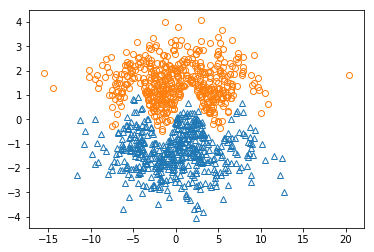

In [6]:
x,y = load_data(500)
x_val, y_val = load_data(100)
## x,y are used for training, and x_val, y_val are used for validation
x_pos = x[y==1]
x_neg = x[y==-1]
plt.plot( x_pos[:,0], x_pos[:,1], "^", markerfacecolor='none' )
plt.plot( x_neg[:,0], x_neg[:,1], "o", markerfacecolor='none' )
plt.show()

From the figure, we can see that these points of two classes are obviously linearly non-separable, therefore we need to use the kernel SVM, and use Gaussian Kernel. Note that in the Gaussian Kernel there is a parameter: sigma, which represents the standard deviation. 

The SVM results are very sensitive to the selection of sigma. 
1. If sigma is too small, the model is going to overfit. Then the training/validation accuracy would be high, but the percentage of support vectors will be extremely high -- almost every point is a support vector! 
2. If sigma is too large, the model is going to underfit. The percentage of suport vector "might" be lower. However, the training/validation accuracy is low, which means the separating hyperplane is not accurately learned.

In this experiment, I used an empirical way to estimate the sigma: 
> Given the training dataset $X$, we use the function distance_matrix($X$,$X$) to compute the distance matrix w.r.t the element in $X$. Then we can use the average value of the distances between point pairs. Moreover, we can use a factor, such as 0.5, to adjust the value of $\sigma$.

In [7]:
estimated_sigma = np.mean( distance_matrix( x,x ) ) * 0.5
print(estimated_sigma)
svm= SVM_Solver( kernel_type = {"name":"GAUSSIAN", "params":[estimated_sigma] } )

2.800322186496282


Then, we can train our SVM model!

In [8]:
svm.train(x,y, x_val, y_val, max_iter = 200000)

Iteration: 10000, 	Train accuracy: 99.10%, 	Val accuracy: 98.00%, 	Delta Objective Function: inf, 	Support Ratio: 19.40%
Iteration: 20000, 	Train accuracy: 99.80%, 	Val accuracy: 99.00%, 	Delta Objective Function: 51.337039, 	Support Ratio: 16.10%
Iteration: 30000, 	Train accuracy: 99.90%, 	Val accuracy: 99.50%, 	Delta Objective Function: 26.450561, 	Support Ratio: 14.00%
Iteration: 40000, 	Train accuracy: 99.40%, 	Val accuracy: 99.50%, 	Delta Objective Function: 10.510557, 	Support Ratio: 14.30%
Iteration: 50000, 	Train accuracy: 99.00%, 	Val accuracy: 98.00%, 	Delta Objective Function: 8.315844, 	Support Ratio: 13.70%
Iteration: 60000, 	Train accuracy: 99.00%, 	Val accuracy: 99.00%, 	Delta Objective Function: 6.098615, 	Support Ratio: 12.70%
Iteration: 70000, 	Train accuracy: 99.70%, 	Val accuracy: 99.00%, 	Delta Objective Function: 6.163077, 	Support Ratio: 12.20%
Iteration: 80000, 	Train accuracy: 100.00%, 	Val accuracy: 99.50%, 	Delta Objective Function: 4.421311, 	Support Ratio: 

Ok, let's have a lM results by plotting it!

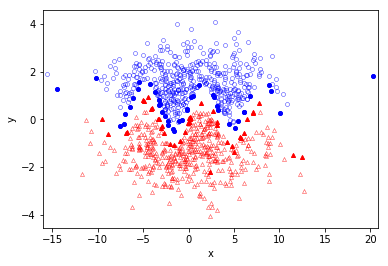

In [9]:
plot_results( x,y, svm.support_ind, pred_y= svm.predict(x), title = "",show_img = True )

Several conclusions can be drawn:
1. the training dataset is correctly separated, which implies an accurate separating hyperplane;
2. The support vectors (points with solid color) are only located around the margin area, which indicates a good selection of the kernel parametes. This SVM is neithet overfit nor underfit.

We can further evaluate the accuracy on test dataset:

In [10]:
x_test, y_test = load_data( 500 )

pred_y=svm.predict(x_test)
test_acc =  np.sum( pred_y == y_test  )/ y_test.shape[0]
print("Test Accuracy: %.2f%%"%(test_acc *100))

Test Accuracy: 99.50%


## Test the kernel SVM on MNIST for classification

To further prove the effectiveness of the SVM model, we tested it on a slightly more complex problem: ditingush between digit "4" and digit "9" using SVM.

First of all, we need to load and prepare the data

In [11]:
## load data
(mnist_x, mnist_y), _ = mnist.load_data()

## extract the digit "4" images (positive 1) and digit "9" images (negative 1)
x_pos= mnist_x[mnist_y == 4]
y_pos= np.ones( x_pos.shape[0] )
x_neg= mnist_x[mnist_y == 9]
y_neg= np.ones( x_neg.shape[0] ) *(-1)

## Put both positive/negative samples together to get the train/val/test dataset
x = np.concatenate( [ x_pos, x_neg ], axis =0 )
x = np.reshape(x, [x.shape[0],-1] )/255   ## normalization
y = np.concatenate( [ y_pos, y_neg], axis =0 )

## randomly shuffle
random_indx = np.random.permutation( np.arange( x.shape[0] ) )
x = x[random_indx]
y = y[random_indx]

## get x,y x_val, y_val, x_test, y_test
x_val = x[:500]
y_val = y[:500]
x_test = x[500:1000]
y_test = y[500:1000]
x = x[1000:2000]
y = y[1000:2000]

Train the SVM model

In [ ]:
## Estimate the value of sigma
sigma_mnist = np.mean( distance_matrix( x,y ) )*0.5

svm_mnist = SVM_Solver( kernel_type = {"name":"GAUSSIAN", "params":[sigma_mnist]} )
svm_mnist.train( x,y, x_val, y_val )

Iteration: 10000, 	Train accuracy: 98.70%, 	Val accuracy: 96.40%, 	Delta Objective Function: inf, 	Support Ratio: 34.50%
Iteration: 20000, 	Train accuracy: 98.60%, 	Val accuracy: 96.00%, 	Delta Objective Function: 92.534743, 	Support Ratio: 29.50%
Iteration: 30000, 	Train accuracy: 98.60%, 	Val accuracy: 95.80%, 	Delta Objective Function: 17.440160, 	Support Ratio: 27.20%
Iteration: 40000, 	Train accuracy: 98.80%, 	Val accuracy: 95.60%, 	Delta Objective Function: 5.375707, 	Support Ratio: 25.50%
Iteration: 50000, 	Train accuracy: 98.90%, 	Val accuracy: 95.40%, 	Delta Objective Function: 2.259709, 	Support Ratio: 24.40%
Iteration: 60000, 	Train accuracy: 98.80%, 	Val accuracy: 95.40%, 	Delta Objective Function: 1.122565, 	Support Ratio: 23.70%
Iteration: 70000, 	Train accuracy: 98.70%, 	Val accuracy: 94.20%, 	Delta Objective Function: 0.762315, 	Support Ratio: 23.90%
Iteration: 80000, 	Train accuracy: 98.80%, 	Val accuracy: 95.40%, 	Delta Objective Function: 0.425399, 	Support Ratio: 23

The Delta Objective Function is now less than epsilon= 1E-4, so the training is finished. Now we can test the classification results on test dataset.

In [ ]:
pred_y=svm_mnist.predict(x_test)
test_acc =  np.sum( pred_y == y_test  )/ y_test.shape[0]
print("Test Accuracy: %.2f%%"%(test_acc *100))

Moreover, we can also have a look of the support_x to see what do the support vectors look like:

In [ ]:
support_x_pos = svm_mnist.support_x[ svm_mnist.support_y==1 ]
support_x_neg = svm_mnist.support_x[ svm_mnist.support_y==-1 ]

fig=plt.figure(figsize=(10, 2), dpi= 80, facecolor='w', edgecolor='k')
plt.gray()
for i in range( 10 ):
    plt.subplot(2,10,i+1)
    plt.imshow( np.reshape(support_x_pos[i,:],[28,28] ))
    plt.title("digit 4")
    plt.axis('off')
    
for i in range( 10 ):
    plt.subplot(2,10,i+11)
    plt.imshow( np.reshape(support_x_neg[i,:],[28,28] ))
    plt.title("digit 9")
    plt.axis('off')

plt.subplots_adjust(wspace=1,  hspace=1)
plt.show()

From the results we can see the support vectors are somehow ambiguous to distingush. E.g, the first digit 4 looks also like digit 9, and the first digit 9 also looks like digit 4. The SVM model is sensitive to such ambiguous samples and tend to use them as support vectors to determine the separating hyperplane.

**Conclusion**

In these long serises, we mathematically show the principle of SVM and many possible solutions to thi problem. We also show the implementation and performance on some small but interesting samples. Hope this could be somehow helpful.

**Reference**
1. [Andrew Ng's course on Machine Learning at Stanford University](http://cs229.stanford.edu/notes/)
2. [Prof. Mathar Rudolf's course on Fundamental of Big Data Analytics](http://www.ti.rwth-aachen.de)
3. [SVM中，高斯核为什么会把原始维度映射到无穷多维？](https://www.zhihu.com/question/35602879)
4. [机器学习算法实践-SVM中的SMO算法- 知乎](https://zhuanlan.zhihu.com/p/29212107)